Handwritten Digit Classification on MNIST Dataset. This project implements a feedforward neural network to classify handwritten digits (0-9) from the MNIST dataset.

Этот проект обучает полносвязную нейронную сеть для классификации рукописных цифр (0-9) из датасета MNIST с использованием PyTorch. Объяснения для каждого блока кода предоставлены на английском и русском языках.

Author: Iosebi Pataraia
GitHub: https://github.com/SosoPataraia


Imports libraries for building, training, and visualizing a neural network. Sets random seed for consistent results.

Импортирует библиотеки для создания, обучения и визуализации нейронной сети. Устанавливает случайное начальное число для воспроизводимости.



In [ ]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Downloads MNIST dataset, converts images to tensors, and splits training data into training and validation sets.  

Загружает датасет MNIST, преобразует изображения в тензоры и разделяет тренировочные данные на тренировочные и валидационные.

In [21]:
# Apply ToTensor transform to convert images to PyTorch tensors
mnist_dataset = torchvision.datasets.MNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='data/', train=False, download=True, transform=transforms.ToTensor())

# Split training data into training and validation sets
train_data, val_data = random_split(mnist_dataset, [50000, 10000])

Creates DataLoaders to load data in batches for training, validation, and testing. Shuffles training data.

Создает DataLoaders для загрузки данных партиями для обучения, валидации и тестирования. Перемешивает тренировочные данные.



In [22]:
# Define batch size and create DataLoaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Defines a neural network with two hidden layers, ReLU, and dropout. Includes methods for training, validation, and reporting results.

Определяет нейронную сеть с двумя скрытыми слоями, ReLU и выбросом. Включает методы для обучения, валидации и вывода результатов.



In [23]:
# Define the neural network model
class MnistModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, num_classes)  # Output layer
        self.relu = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization

    def forward(self, xb):
        xb = xb.reshape(-1, 784)  # Flatten input (batch_size, 1, 28, 28) -> (batch_size, 784)
        out = self.relu(self.fc1(xb))  # First layer with ReLU
        out = self.dropout(out)  # Apply dropout
        out = self.relu(self.fc2(out))  # Second layer with ReLU
        out = self.dropout(out)  # Apply dropout
        out = self.fc3(out)  # Output layer (logits)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Compute loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [26]:
# Define accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
# Evaluation function
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    return model.validation_epoch_end(outputs)

Trains the model for specified epochs, updating weights and evaluating performance after each epoch.

Обучает модель в течение указанных эпох, обновляя веса и оценивая производительность после каждой эпохи.



In [24]:
# Training function
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Initializes the model, evaluates it before training, trains for 10 epochs, and plots validation accuracy over epochs.

Инициализирует модель, оценивает до обучения, обучает 10 эпох и строит график точности валидации по эпохам.



Initial validation: {'val_loss': 2.306532382965088, 'val_acc': 0.08020173758268356}
Epoch [1], val_loss: 0.2255, val_acc: 0.9326
Epoch [2], val_loss: 0.1488, val_acc: 0.9562
Epoch [3], val_loss: 0.1202, val_acc: 0.9653
Epoch [4], val_loss: 0.1022, val_acc: 0.9690
Epoch [5], val_loss: 0.0968, val_acc: 0.9705
Epoch [6], val_loss: 0.0928, val_acc: 0.9723
Epoch [7], val_loss: 0.0892, val_acc: 0.9749
Epoch [8], val_loss: 0.0871, val_acc: 0.9755
Epoch [9], val_loss: 0.0791, val_acc: 0.9762
Epoch [10], val_loss: 0.0821, val_acc: 0.9769


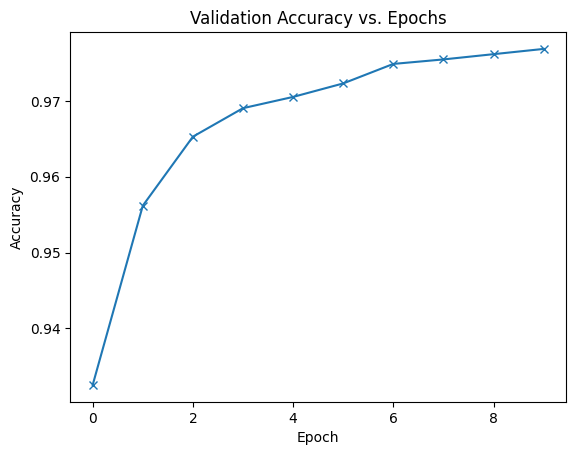

In [27]:
# Initialize model and train
model = MnistModel()
result0 = evaluate(model, val_loader)
print("Initial validation:", result0)

# Train for 10 epochs with learning rate 0.001
history = fit(10, 0.001, model, train_loader, val_loader)

# Plot accuracy over epochs
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.show()

In [28]:
# Evaluate on test set
test_result = evaluate(model, test_loader)
print("Test set performance:", test_result)

Test set performance: {'val_loss': 0.073357954621315, 'val_acc': 0.9779469966888428}


Defines a function to predict a single image’s label and displays six test images with true and predicted labels.

Определяет функцию для предсказания метки изображения и отображает шесть тестовых изображений с истинными и предсказанными метками.



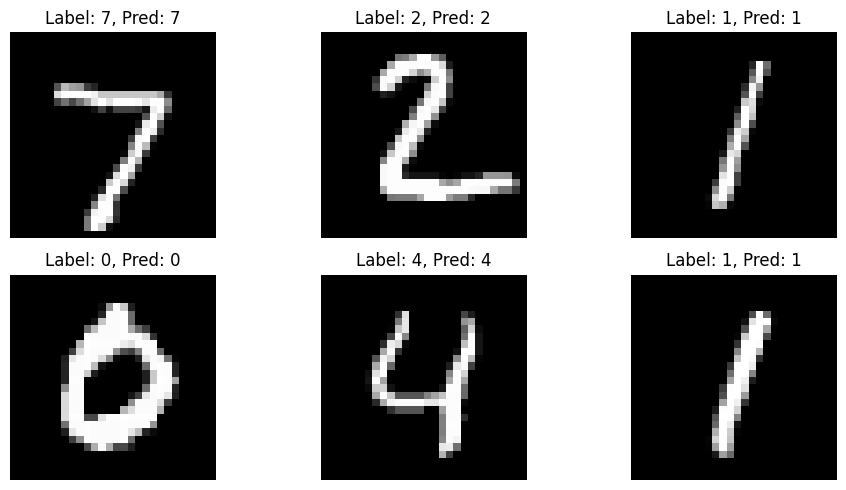

In [33]:
# Visualize sample predictions
def predict_image(img, model):
    xb = img.unsqueeze(0)  # Add batch dimension
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

# Display a few test images with predictions
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img, label = test_dataset[i]
    pred = predict_image(img, model)
    ax.imshow(img[0], cmap='gray')
    ax.set_title(f"Label: {label}, Pred: {pred}")
    ax.axis('off')
plt.tight_layout()
plt.show()

Generates and visualizes a confusion matrix to show model performance across all classes.

Создает и визуализирует матрицу ошибок для отображения производительности модели по всем классам.



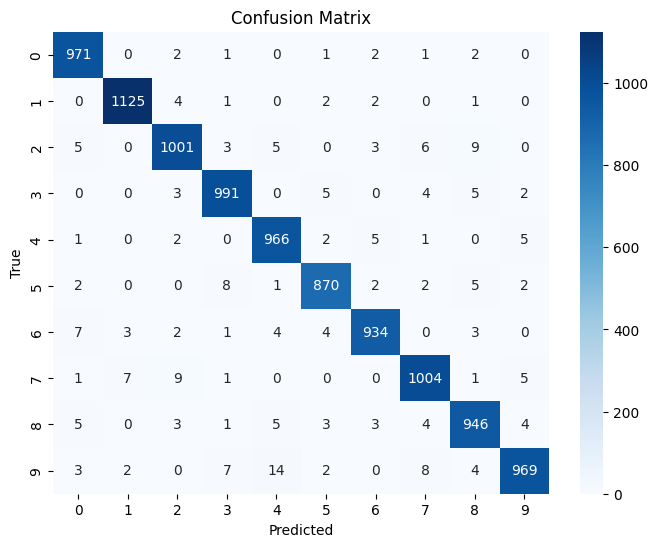

In [34]:
# Generate confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Save the model
torch.save(model.state_dict(), 'mnist_mlp.pth')

# Load and verify model
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist_mlp.pth'))
test_result2 = evaluate(model2, test_loader)
print("Loaded model test performance:", test_result2)

Loaded model test performance: {'val_loss': 0.073357954621315, 'val_acc': 0.9779469966888428}
